# ORTHOGONAL POLYNOMIAL DENSITY ESTIMATION
## Preliminaries
### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
from uuid import uuid4

from lpde.geometry import WidthOf, Window, PointAt, BoundingBox, Mapper, Grid
from lpde.estimators import Parallel
from lpde.estimators.datatypes import Event, Degree, Action, Scalings, Signal

### Notebook settings

In [2]:
%matplotlib notebook

## Density Estimation
### Initialize

In [3]:
legendre_width = WidthOf(1.8)

center = PointAt(0, 0)
window = Window(1.8, 1.8)
bounds = BoundingBox(center, window)

mapper = Mapper(bounds, legendre_width)

degree = Degree(20, 20)
density = Parallel(degree, mapper)

action = Action.ADD
point = PointAt(0.5, 0.5)
event = Event(uuid4(), action, point)

grid = Grid(100, 100)

### Create mock data streams

In [4]:
def gaussian():
    x, y = np.random.multivariate_normal((0,0), ((0.1,0), (0,0.1)))
    if (-0.9 <= x <= 0.9) and (-0.9 <= y <= 0.9):
        return x, y
    else:
        return gaussian()

def uniform():
    return np.random.uniform(low=-0.9, high=0.9, size=2)

locations = []

def new_event(dist):
    location = dist()
    locations.append(location)
    point = PointAt(*location)
    return Event(uuid4(), Action(1), point)

def random_event(dist):
    event_type = np.random.randint(low=-1, high=2)
    if event_type == 1:
        location = dist()
        point = PointAt(*location)
        return Event(uuid4(), Action(1), point)
    elif event_type == 0:
        location = dist()
        point = PointAt(*location)
        column = density._phi.sample(1, axis=1).columns.values[0]
        return Event(column, Action(0), point)
    column = density._phi.sample(1, axis=1).columns.values[0]
    return Event(column, Action(-1))

In [5]:
density.estimator.start(1, 1.0)

/Users/georg/Documents/Python/LPDE/lpde/estimators/parallel/minimizer.py:78: RuntimeWarning: overflow encountered in double_scalars
  return self.__neg_log_l(c[1:]) + c[0]*self.__norm(c[1:])


In [18]:
density.update_with(new_event(gaussian))

In [7]:
density.at(point)

0.2382515834870243

In [37]:
density.estimator.stop()

In [ ]:
density.estimator._Estimator__phi_queue.join_thread()

In [ ]:
density.estimator._Estimator__minimizers

In [ ]:
try:
    density._Parallel__phi_queue.put('ada')
except AssertionError:
    print('suis')

### Timings of density estimation

In [ ]:
%%time
for i in range(1000):
    density.update_with(new_event(gaussian))
while not density._phi_queue_empty:
    pass

In [ ]:
%%time
for i in range(1000):
    density.update_with(random_event(gaussian))
while not density._phi_queue_empty:
    pass

In [ ]:
%%time
for i in range(1000):
    density.at(new_event(uniform).location)
while not density._phi_queue_empty:
    pass

__Timings__

33 ms per additive update with uniform distribution

31 ms per random update with uniform distribution

0.6 ms per evaluation at point

In [10]:
locations

[(0.052648015168593278, 0.34943582130680645)]

### Plot final density

<IPython.core.display.Javascript object>


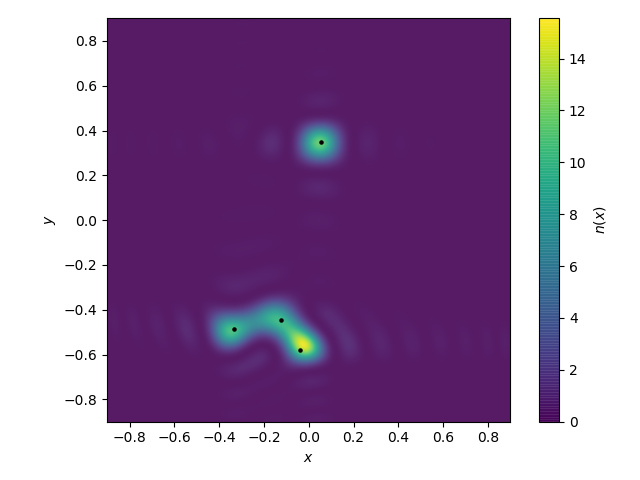

In [49]:
n_hat = density.on(grid)

fig, ax = plt.subplots()
ax.set(xlabel=r'$x$', ylabel=r'$y$')
ax.scatter(*zip(*locations), s=5, c='k')
contour = ax.imshow(n_hat,
                    cmap='viridis',
                    alpha=0.9,
                    extent=2*mapper.legendre_interval,
                    origin='lower',
                    interpolation='bicubic')
cbar = plt.colorbar(contour, ax=ax, label=r'$n(x)$')
fig.tight_layout()